In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [2]:
data = pd.read_csv("train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')
store = pd.read_csv("store.csv",low_memory=False)
test = pd.read_csv("test.csv", 
                   parse_dates = True,low_memory=False, index_col = 'Date')

# Filling missing values

In [3]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [4]:
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [5]:
store["CompetitionDistance"].fillna(value=store["CompetitionDistance"].median(),inplace=True)

In [6]:
store.fillna(value = 0,inplace=True)

In [7]:
test.fillna(value = 1,inplace=True)

# Split Training Data (last 6 weeks as test set)

In [18]:
ho_test = data[:6*7*1115]
ho_train = data[6*7*1115:]

# Feature Engineering

In [19]:
def transfer_date(data):
    data['Year'] = data.index.year
    data['Month'] = data.index.month
    data['Day'] = data.index.day
    data['DayOfWeek'] = data.index.dayofweek
    data['WeekOfYear'] = data.index.weekofyear
    return data
def features_engineering(data):
    mappings = {'0':0,'a':1,'b':2,'c':3,'d':4}
    data.StoreType.replace(mappings, inplace = True)
    data.Assortment.replace(mappings, inplace = True)
    data.StateHoliday.replace(mappings, inplace = True)
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data
ho_test = transfer_date(ho_test)
ho_test = pd.merge(ho_test,store,how = 'inner',on="Store")
ho_test = features_engineering(ho_test)
ho_train = transfer_date(ho_train)
ho_train = pd.merge(ho_train,store,how = 'inner',on="Store")
ho_train = features_engineering(ho_train)
ho_train

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,4,4202,487,1,1,0,0,2015,6,...,9.0,2008.0,0,0.0,0.0,,81.0,24186.25,Jun,0
1,1,3,4645,498,1,1,0,0,2015,6,...,9.0,2008.0,0,0.0,0.0,,81.0,24186.25,Jun,0
2,1,2,4000,476,1,1,0,0,2015,6,...,9.0,2008.0,0,0.0,0.0,,81.0,24186.25,Jun,0
3,1,1,4852,503,1,1,0,0,2015,6,...,9.0,2008.0,0,0.0,0.0,,81.0,24186.25,Jun,0
4,1,0,5518,586,1,1,0,0,2015,6,...,9.0,2008.0,0,0.0,0.0,,81.0,24186.25,Jun,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970374,1115,5,4771,339,1,0,0,1,2013,1,...,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",24157.0,6.75,Jan,0
970375,1115,4,4540,326,1,0,0,1,2013,1,...,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",24157.0,6.75,Jan,0
970376,1115,3,4297,300,1,0,0,1,2013,1,...,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",24157.0,6.75,Jan,0
970377,1115,2,3697,305,1,0,0,1,2013,1,...,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",24157.0,6.75,Jan,0


In [20]:
ho_test = ho_test[ho_test["Open"] != 0]
ho_test = ho_test[ho_test["Sales"] > 0]
ho_train = ho_train[ho_train["Open"] != 0]
ho_train = ho_train[ho_train["Sales"] > 0]

In [21]:
ho_test.drop(['Customers','Open','PromoInterval','monthStr'],axis=1,inplace =True)
ho_train.drop(['Customers','Open','PromoInterval','monthStr'],axis=1,inplace =True)

In [22]:
ho_xtrain = ho_train.drop(['Sales'],axis=1)
ho_ytrain = np.log1p(ho_train.Sales)
ho_xtest = ho_test.drop(['Sales'],axis=1 )
ho_ytest = np.log1p(ho_test.Sales)

In [23]:
test = transfer_date(test)
test = pd.merge(test,store,how = 'inner',on="Store")
test = features_engineering(test)
test

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,1,3,1.0,1,0,0,2015,9,17,...,9.0,2008.0,0,0.0,0.0,,84.0,24189.50,Sept,0
1,857,1,2,1.0,1,0,0,2015,9,16,...,9.0,2008.0,0,0.0,0.0,,84.0,24189.50,Sept,0
2,1713,1,1,1.0,1,0,0,2015,9,15,...,9.0,2008.0,0,0.0,0.0,,84.0,24189.50,Sept,0
3,2569,1,0,1.0,1,0,0,2015,9,14,...,9.0,2008.0,0,0.0,0.0,,84.0,24189.50,Sept,0
4,3425,1,6,0.0,0,0,0,2015,9,13,...,9.0,2008.0,0,0.0,0.0,,84.0,24189.25,Sept,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,37664,1115,2,1.0,1,0,1,2015,8,5,...,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",24188.0,38.50,Aug,0
41084,38520,1115,1,1.0,1,0,1,2015,8,4,...,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",24188.0,38.50,Aug,0
41085,39376,1115,0,1.0,1,0,1,2015,8,3,...,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",24188.0,38.50,Aug,0
41086,40232,1115,6,0.0,0,0,1,2015,8,2,...,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",24188.0,38.25,Aug,0


In [24]:
xtest =test.drop(['Id','Open','PromoInterval','monthStr'],axis = 1)

In [25]:
def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [352]:
import xgboost as xgb
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.03,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 10
          }
num_boost_round = 6000


dtrain = xgb.DMatrix(ho_xtrain,ho_ytrain)
dvalid = xgb.DMatrix(ho_xtest,ho_ytest)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]


print("Train a XGBoost model")

gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)


print("validating")
ho_xtest.sort_index(inplace=True) 
ho_ytest.sort_index(inplace=True) 
yhat = gbm.predict(xgb.DMatrix(ho_xtest))
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat))

print('RMSPE: {:.6f}'.format(error))

Train a XGBoost model
[15:38:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[15:38:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:8.02254	train-rmspe:0.99981	eval-rmse:7.98995	eval-rmspe:0.99981
[1]	train-rmse:7.78232	train-rmspe:0.99971	eval-rmse:7.74899	eval-rmspe:0.99971
[2]	train-rmse:7.54937	train-rmspe:0.99959	eval-rmse:7.51611	eval-rmspe:0.99959
[3]	train-rmse:7.32335	train-rmspe:0.99945	eval-rmse:7.29013	eval-rmspe:0.99944
[4]	train-rmse:7.10415	train-rmspe:0.99927	eval-rmse:7.07036	eval-rmspe:0.99926
[5]	train-rmse:6.89155	train-rmspe:0.99906	eval-rmse:6.85703	eval-rmspe:0.99904
[6]	train-rmse:6.68540	train-rmspe:0.99880	eval-rmse:6.65077	eval-rmspe:0.99878
[7]	train-rmse:6.48537	

In [345]:
# analysis by hold-out set
res = pd.DataFrame(data = ho_ytest)
res['Prediction']=yhat
res = pd.merge(ho_xtest,res, left_index= True, right_index=True)
res['Ratio'] = res.Prediction/res.Sales
res['Error'] =abs(res.Ratio-1)
res['Weight'] = res.Sales/res.Prediction
res.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,...,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
0,1,4,1,0,1,2015,7,31,31,3,...,0.0,0.0,82.0,24187.75,0,8.568646,8.889361,1.037429,0.037429,0.963921
1,1,3,1,0,1,2015,7,30,31,3,...,0.0,0.0,82.0,24187.75,0,8.521384,8.830783,1.036308,0.036308,0.964964
2,1,2,1,0,1,2015,7,29,31,3,...,0.0,0.0,82.0,24187.75,0,8.472823,8.791418,1.037602,0.037602,0.963761
3,1,1,1,0,1,2015,7,28,31,3,...,0.0,0.0,82.0,24187.75,0,8.519590,8.878339,1.042109,0.042109,0.959593
4,1,0,1,0,1,2015,7,27,31,3,...,0.0,0.0,82.0,24187.75,0,8.716536,9.022480,1.035099,0.035099,0.966091


Mean Ratio of predition and real sales data is 0.9971547840676495: store all
Mean Ratio of predition and real sales data is nan: store 437
Mean Ratio of predition and real sales data is nan: store 443
Mean Ratio of predition and real sales data is nan: store 304


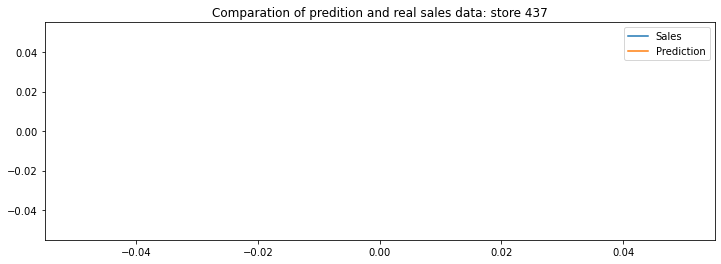

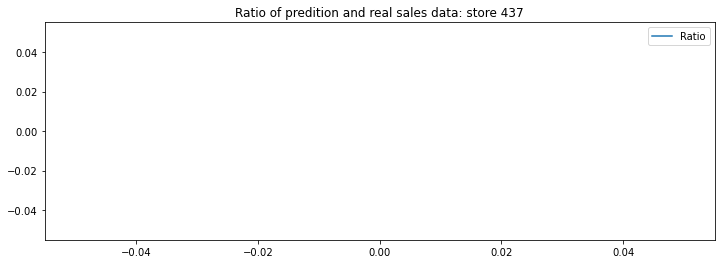

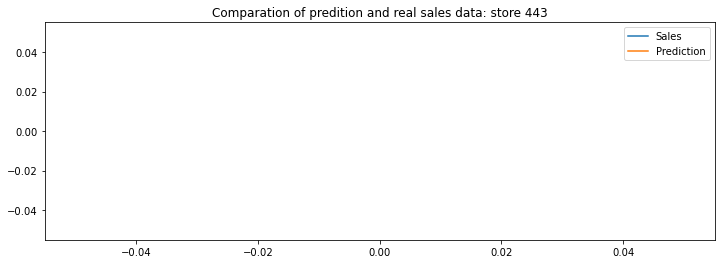

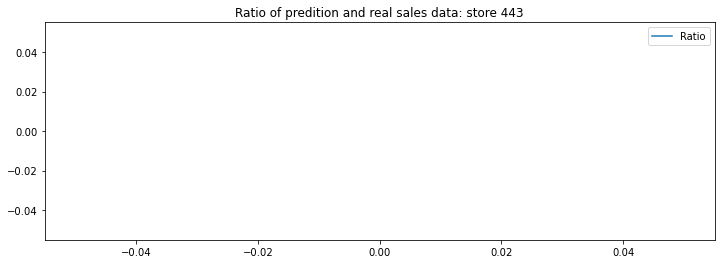

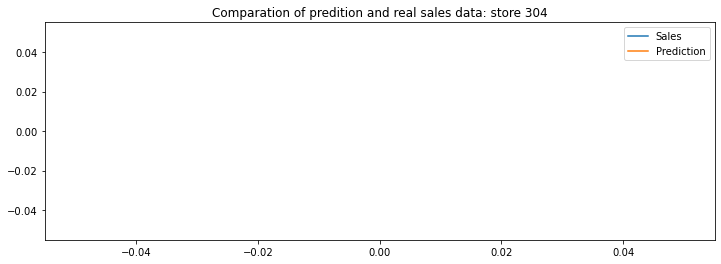

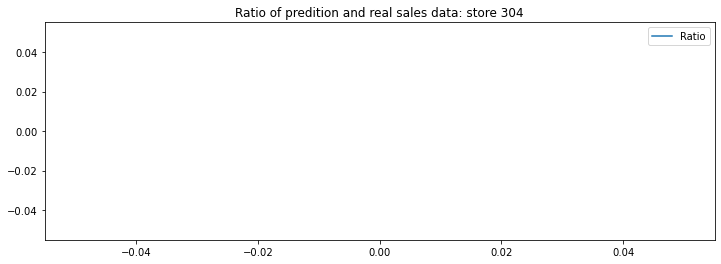

In [346]:
col_1 = ['Sales','Prediction']
col_2 = ['Ratio']
L=np.random.randint( low=1,high = 1115, size = 3 ) 
print('Mean Ratio of predition and real sales data is {}: store all'.format(res.Ratio.mean()))
for i in L:
    s1 = pd.DataFrame(res[res['Store']==i],columns = col_1)
    s2 = pd.DataFrame(res[res['Store']==i],columns = col_2)
    s1.plot(title = 'Comparation of predition and real sales data: store {}'.format(i),figsize=(12,4))
    s2.plot(title = 'Ratio of predition and real sales data: store {}'.format(i),figsize=(12,4))
    print('Mean Ratio of predition and real sales data is {}: store {}'.format(s2.Ratio.mean(),i))


In [347]:
# the worst 10 samples
res.sort_values(['Error'],ascending=False,inplace= True)
res[:10]

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,...,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
27666,30,0,0,0,0,2013,2,11,7,1,...,10.0,2014.0,0.0,0.00,0,6.418365,8.738984,1.361559,0.361559,0.734452
36722,40,3,1,0,0,2013,2,7,6,1,...,45.0,2009.0,24158.0,38.25,1,7.167038,8.916880,1.244151,0.244151,0.803761
35987,40,3,0,0,0,2015,2,12,7,1,...,45.0,2009.0,24182.0,62.50,1,6.959399,8.623327,1.239091,0.239091,0.807043
45741,50,1,0,0,0,2013,3,12,11,4,...,0.0,0.0,40.0,24158.75,0,7.069023,8.453641,1.195871,0.195871,0.836211
36337,40,3,0,0,0,2014,2,27,9,1,...,45.0,2009.0,24170.0,51.00,1,7.212294,8.561369,1.187052,0.187052,0.842423
41215,45,1,0,0,0,2013,3,12,11,4,...,0.0,0.0,0.0,24158.75,0,7.138073,8.452703,1.184172,0.184172,0.844472
27285,30,3,0,0,0,2014,2,27,9,1,...,10.0,2014.0,0.0,0.00,0,7.464510,8.755981,1.173015,0.173015,0.852504
26935,30,3,0,0,0,2015,2,12,7,1,...,10.0,2014.0,12.0,11.25,0,7.379008,8.565938,1.160852,0.160852,0.861436
22588,25,4,0,0,0,2014,2,14,7,3,...,0.0,0.0,130.0,24169.75,0,10.121940,8.506540,0.840406,0.159594,1.189901
22619,25,1,0,0,0,2014,1,14,3,3,...,0.0,0.0,129.0,24168.75,0,7.252054,8.393696,1.157423,0.157423,0.863988


weight correction
RMSPE for 0.990:0.294316
RMSPE for 0.991:0.294829
RMSPE for 0.992:0.295593
RMSPE for 0.993:0.296610
RMSPE for 0.994:0.297886
RMSPE for 0.995:0.299424
RMSPE for 0.996:0.301226
RMSPE for 0.997:0.303295
RMSPE for 0.998:0.305632
RMSPE for 0.999:0.308239
RMSPE for 1.000:0.311114
RMSPE for 1.001:0.314260
RMSPE for 1.002:0.317673
RMSPE for 1.003:0.321355
RMSPE for 1.004:0.325301
RMSPE for 1.005:0.329512
RMSPE for 1.006:0.333984
RMSPE for 1.007:0.338713
RMSPE for 1.008:0.343699
RMSPE for 1.009:0.348935
Best weight for Score:0.99    0.294316
dtype: float64


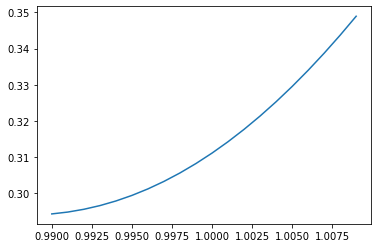

In [348]:
# whole correction
print("weight correction")
W=[(0.990+(i/1000)) for i in range(20)]
S =[]
for w in W:
    error = rmspe(np.expm1(ho_ytest), np.expm1(yhat*w))
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

In [349]:
# correction by store
L=range(1115)
W_ho=[]
W_test=[]
for i in L:
    s1 = pd.DataFrame(res[res['Store']==i+1],columns = col_1)
    s2 = pd.DataFrame(xtest[xtest['Store']==i+1])
    W1=[(0.990+(i/1000)) for i in range(20)]
    S =[]
    for w in W1:
        error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
        S.append(error)
    Score = pd.Series(S,index=W1)
    BS = Score[Score.values == Score.values.min()]
    a=np.array(BS.index.values)
    b_ho=a.repeat(len(s1))
    b_test=a.repeat(len(s2))
    W_ho.extend(b_ho.tolist())
    W_test.extend(b_test.tolist())

In [350]:
yhat_new = yhat*W_ho
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat_new))
print ('RMSPE for weight corretion {:6f}'.format(error))

RMSPE for weight corretion 0.256739


In [353]:
print("Make predictions on the test set")
dtest = xgb.DMatrix(xtest)
test_probs = gbm.predict(dtest)

# model1  kaggle private score 0.12647
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs)})
result.to_csv("Rossmann_submission_1.csv", index=False)

# model2 kaggle private score 0.11756
#result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs*0.995)})
#result.to_csv("Rossmann_submission_2.csv", index=False)

# model3 kaggle private score 0.11292
#result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs*W_test)})
#result.to_csv("Rossmann_submission_3.csv", index=False)



Make predictions on the test set


In [26]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

Model_1 = XGBRegressor(learning_rate=0.1,n_estimators=400,max_depth=8)
Model_1.fit(ho_xtrain,ho_ytrain.values,eval_set=[(ho_xtest,ho_ytest)])


print("Make predictions on the test set")
y_pred = Model_1.predict(ho_xtest)
error = rmspe(ho_ytest,y_pred)
print("accuarcy: %.2f%%" % (error*100.0))
Test_Pred = Model_1.predict(xtest)

result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(Test_Pred)})
result.to_csv("Rossmann_submission_1.csv", index=False)

[0]	validation_0-rmse:7.45106
[1]	validation_0-rmse:6.70913
[2]	validation_0-rmse:6.04197
[3]	validation_0-rmse:5.44118
[4]	validation_0-rmse:4.90075
[5]	validation_0-rmse:4.41353
[6]	validation_0-rmse:3.97432
[7]	validation_0-rmse:3.58038
[8]	validation_0-rmse:3.22471
[9]	validation_0-rmse:2.90575
[10]	validation_0-rmse:2.61859
[11]	validation_0-rmse:2.36166
[12]	validation_0-rmse:2.13008
[13]	validation_0-rmse:1.91775
[14]	validation_0-rmse:1.72889
[15]	validation_0-rmse:1.56154
[16]	validation_0-rmse:1.41007
[17]	validation_0-rmse:1.27432
[18]	validation_0-rmse:1.15446
[19]	validation_0-rmse:1.04600
[20]	validation_0-rmse:0.94883
[21]	validation_0-rmse:0.86195
[22]	validation_0-rmse:0.78572
[23]	validation_0-rmse:0.71872
[24]	validation_0-rmse:0.65737
[25]	validation_0-rmse:0.60343
[26]	validation_0-rmse:0.55596
[27]	validation_0-rmse:0.51450
[28]	validation_0-rmse:0.47764
[29]	validation_0-rmse:0.44471
[30]	validation_0-rmse:0.41584
[31]	validation_0-rmse:0.39224
[32]	validation_0-

In [366]:
Model_2 = XGBRegressor(learning_rate=0.1,n_estimators=100,max_depth=6,min_child_weight = 1,
                     subsample=0.8,colsample_btree=0.8,objective='reg:linear',
                     scale_pos_weight=1,random_state=27)
Model_2.fit(ho_xtrain,ho_ytrain,eval_set = [(ho_xtest,ho_ytest)],eval_metric = "rmse",
          early_stopping_rounds = 50)


print("Make predictions on the test set")
y_pred = Model_2.predict(ho_xtest)
error = rmspe(ho_ytest,y_pred)
print("accuarcy: %.2f%%" % (error*100.0))
Test_Pred = Model_2.predict(xtest)

result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(Test_Pred)})
result.to_csv("Rossmann_submission_1.csv", index=False)

[17:02:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_btree" } are not used.

[0]	validation_0-rmse:7.41167
[1]	validation_0-rmse:6.66927
[2]	validation_0-rmse:6.00094
[3]	validation_0-rmse:5.39992
[4]	validation_0-rmse:4.85916
[5]	validation_0-rmse:4.37260
[6]	validation_0-rmse:3.93429
[7]	validation_0-rmse:3.54057
[8]	validation_0-rmse:3.18640
[9]	validation_0-rmse:2.86865
[10]	validation_0-rmse:2.58214
[11]	validation_0-rmse:2.33027
[12]	validation_0-rmse:2.09966
[13]	validation_0-rmse:1.89165
[14]	validation_0-rmse:1.70538
[15]	validation_0-rmse:1.54285
[16]	validation_0-rmse:1.39312
[17]	validation_0-rmse:1.25761
[18]	validation_0-rmse:1.13772
[19]	validation_0

In [368]:
parameters = {
    'min_child_weight':[2,3,4],
    'colsample_tree':[0.5,0.7,1],
    'scale_pos_weight':[0.6,0.7,0.8]
}
xlf = XGBRegressor(learning_rate=0.1,n_estimators=50,max_depth=5,min_child_weight = 1,
                     subsample=0.8,colsample_btree=0.8,objective='reg:linear',
                     scale_pos_weight=1,random_state=27)
n_iter_search = 5

gsearch = RandomizedSearchCV(xlf, param_distributions=parameters,n_iter=n_iter_search,cv=5)
gsearch.fit(ho_xtrain,ho_ytrain,eval_set = [(ho_xtest,ho_ytest)],eval_metric = "rmse",
          early_stopping_rounds = 20)
best_estimator = gsearch.best_estimator_

[17:09:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_btree", "colsample_tree" } are not used.

[0]	validation_0-rmse:7.40971
[1]	validation_0-rmse:6.66742
[2]	validation_0-rmse:5.99892
[3]	validation_0-rmse:5.39602
[4]	validation_0-rmse:4.85504
[5]	validation_0-rmse:4.36697
[6]	validation_0-rmse:3.92892
[7]	validation_0-rmse:3.53510
[8]	validation_0-rmse:3.18033
[9]	validation_0-rmse:2.86133
[10]	validation_0-rmse:2.57444
[11]	validation_0-rmse:2.31744
[12]	validation_0-rmse:2.08843
[13]	validation_0-rmse:1.88005
[14]	validation_0-rmse:1.69298
[15]	validation_0-rmse:1.52730
[16]	validation_0-rmse:1.37556
[17]	validation_0-rmse:1.24127
[18]	validation_0-rmse:1.12427

In [369]:
best_estimator

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_btree=0.8, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=1, colsample_tree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=0,
             num_parallel_tree=1, ...)

In [371]:
best_estimator.fit(ho_xtrain,ho_ytrain,eval_set = [(ho_xtest,ho_ytest)],eval_metric = "rmse",
          early_stopping_rounds = 50)
print("Make predictions on the test set")
y_pred = best_estimator.predict(ho_xtest)
error = rmspe(ho_ytest,y_pred)
print("accuarcy: %.2f%%" % (error*100.0))
Test_Pred = best_estimator.predict(xtest)
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(Test_Pred)})
result.to_csv("Rossmann_submission_1.csv", index=False)

[17:18:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:18:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_btree", "colsample_tree" } are not used.

[0]	validation_0-rmse:7.41188
[1]	validation_0-rmse:6.66949
[2]	validation_0-rmse:6.00098
[3]	validation_0-rmse:5.39836
[4]	validation_0-rmse:4.85697
[5]	validation_0-rmse:4.37099
[6]	validation_0-rmse:3.93315
[7]	validation_0-rmse:3.53908
[8]	validation_0-rmse:3.18498
[9]	validation_0-rmse:2.86614
[10]	validation_0-rmse:2.58035
[11]	validation_0-rmse:2.32265
[12]	validation_0-rmse:2.09212
[13]	validation_0-rmse:1.88471
[14]	validation_0-rmse:1.69916
[15]	validation_0-rmse:1.53769
[16]	validation_0-rmse:1.38842
[17]	validation_0-rmse:1.25478
[18]	validation_0-rmse:1.13461

In [373]:

parameters = {
    'n_estimators':[100,200,300,400],   
    'max_depth':[5,7,9]  
}

xlf = XGBRegressor(learning_rate=0.1,n_estimators=50,max_depth=5,min_child_weight = 1,
                     subsample=0.8,colsample_btree=0.8,objective='reg:linear',
                     scale_pos_weight=1,random_state=27)
n_iter_search = 5

gsearch = RandomizedSearchCV(xlf,param_distributions=parameters,n_iter=n_iter_search, cv=5)

gsearch.fit(ho_xtrain,ho_ytrain,eval_set = [(ho_xtest,ho_ytest)],eval_metric = "rmse",
            early_stopping_rounds = 20)


print("Best score: %0.3f" % gsearch.best_score_)
best_estimator = gsearch.best_estimator_
print("Best parameters set" )
best_estimator

[17:21:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:21:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_btree" } are not used.

[0]	validation_0-rmse:7.40971
[1]	validation_0-rmse:6.66742
[2]	validation_0-rmse:5.99892
[3]	validation_0-rmse:5.39602
[4]	validation_0-rmse:4.85504
[5]	validation_0-rmse:4.36697
[6]	validation_0-rmse:3.92892
[7]	validation_0-rmse:3.53510
[8]	validation_0-rmse:3.18033
[9]	validation_0-rmse:2.86133
[10]	validation_0-rmse:2.57444
[11]	validation_0-rmse:2.31744
[12]	validation_0-rmse:2.08843
[13]	validation_0-rmse:1.88005
[14]	validation_0-rmse:1.69298
[15]	validation_0-rmse:1.52747
[16]	validation_0-rmse:1.37574
[17]	validation_0-rmse:1.24144
[18]	validation_0-rmse:1.12444
[19]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_btree=0.8, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=1, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', ...)

In [374]:
best_estimator.fit(ho_xtrain,ho_ytrain,eval_set = [(ho_xtest,ho_ytest)],eval_metric = "rmse",
          early_stopping_rounds = 50)
print("Make predictions on the test set")
y_pred = best_estimator.predict(ho_xtest)
error = rmspe(ho_ytest,y_pred)
print("accuarcy: %.2f%%" % (error*100.0))
Test_Pred = best_estimator.predict(xtest)
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(Test_Pred)})
result.to_csv("Rossmann_submission_1.csv", index=False)

[17:37:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:37:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_btree" } are not used.

[0]	validation_0-rmse:7.41188
[1]	validation_0-rmse:6.66949
[2]	validation_0-rmse:6.00098
[3]	validation_0-rmse:5.39836
[4]	validation_0-rmse:4.85697
[5]	validation_0-rmse:4.37099
[6]	validation_0-rmse:3.93315
[7]	validation_0-rmse:3.53908
[8]	validation_0-rmse:3.18498
[9]	validation_0-rmse:2.86614
[10]	validation_0-rmse:2.58035
[11]	validation_0-rmse:2.32265
[12]	validation_0-rmse:2.09212
[13]	validation_0-rmse:1.88471
[14]	validation_0-rmse:1.69916
[15]	validation_0-rmse:1.53769
[16]	validation_0-rmse:1.38842
[17]	validation_0-rmse:1.25478
[18]	validation_0-rmse:1.13461
[19]	validation_0